# Simple CNN vs Efficient Net B0

In this notebook we compare the use of a Simple CNN vs Efficient Net B0 for the classification of skin vs not skin images.

**Conclusion: Simple CNN performs worst with a 70% accuracy on a test, while Efficient Net B0 performs better with a 83% accuracy on a test.**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
% cd './drive/My Drive/'
% ls

In [3]:
# Requirements
! pip install torch
! pip install efficientnet-pytorch

Functions

In [0]:
import random
import os
import numpy as np
import torch


def myseed(seed=42):
    """
    Make results reproducible.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
import os
import pandas as pd

from glob import glob


def load_data(data_dir='/content/drive/My Drive/skin'):
    """ 
    Find .jpg files and create a dataframe.
    """
    myseed(seed=42)

    # Get filenames
    filenames = glob(os.path.join(data_dir, '*','*.jpg'))
    if len(filenames) == 0:
      filenames = glob(os.path.join(data_dir, '*', '*','*.jpg'))

    # Create a dataframe
    df = pd.DataFrame(data=filenames, columns=['filenames'])

    # Get the labels and their one hot encoded values
    df['label'] = df['filenames'].str.extract(r'skin\W(\w+)\W')
    try:
      df['label'] = df['label'].astype('category')
      mapping = dict(enumerate(df['label'].cat.categories ))
    except AttributeError as err:
      mapping = ''
    
    df['label_code'] = pd.Categorical(df['label']).codes
    return df, mapping

In [0]:
from sklearn.model_selection import train_test_split


def data_split(df):
    """ 
    Split images in data_dir into
    train, val, test
    80,20,20
    """
    myseed(seed=42)
    seed = 42
    
    train_val, test = train_test_split(df, test_size=0.2, random_state=seed)
    train_val, test = train_val.reset_index(drop=True), test.reset_index(drop=True)
    train, val = train_test_split(train_val, test_size=0.2, random_state=seed)
    train, val = train.reset_index(drop=True), val.reset_index(drop=True)
    return train, val, test

In [0]:
import torchvision

from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision import transforms


def get_loaders(size=100, batch_size=1, num_workers=1):
    """
    Put data into the dataloaders.
    """
    myseed(seed=42)

    # Custom Pytorch dataloader for this dataset
    class Derm(Dataset):
        """
        Read a pandas dataframe with
        images paths and labels
        """
        def __init__(self, df, transform=None):
            self.df = df
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, index):
            # Load image data and get label
            X = Image.open(self.df['filenames'][index]).convert('RGB')
            y = torch.tensor(int(self.df['label_code'][index]))
            
            if self.transform:
                X = self.transform(X)

            return X, y

    # ImageNet statistics
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Transforms
    data_transforms = {'train' : transforms.Compose([transforms.Resize(size),
                                              transforms.CenterCrop((size,size)),
                                              transforms.RandomRotation(10),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean,std)]),
                       'val' : transforms.Compose([transforms.Resize(size),
                                              transforms.CenterCrop((size,size)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean,std)]),
                       'test' : transforms.Compose([transforms.Resize(size),
                                              transforms.CenterCrop((size,size)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean,std)]),
                       'unknown' : transforms.Compose([transforms.Resize(size),
                                              transforms.CenterCrop((size,size)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean,std)])}
      
    # Frames
    df = {'train': train, 'val': val, 'test': test, 'unknown': unknown}                                    
    # Sets
    image_datasets = {x: Derm(df[x], transform=data_transforms[x]) for x in ['train', 'val', 'test', 'unknown']}
    # Sizes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test', 'unknown']}
    # Loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size, num_workers) for x in ['train', 'val', 'test', 'unknown']}
    return data_transforms, df, image_datasets, dataloaders, dataset_sizes

In [0]:
def compute_conv_dim(d, k, p, s):
    """
    Compute dimention after convolution.
    """
    #return int((input_dimention - kernel_size + 2 * padding) / stride + 1)
    return int((d - k + 2 * p) / s + 1)

### Models

Anja's model

In [0]:
from torch import nn
from efficientnet_pytorch import EfficientNet


def anjamodel(unfreeze=True):
  """
  Unfreeze(True) all the model weights or freeze(False) the convolutional 
  layers only
  """
  myseed(seed=42)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)

  class Net(nn.Module):
        def __init__(self):
            super().__init__()
            #100x100x3
            self.conv1 = nn.Conv2d(3,16,3) 
            #print(compute_conv_dim(100,3,0,1))
            #98x98x16
            self.conv2 = nn.Conv2d(16,16,3) 
            #print(compute_conv_dim(98,3,0,1))
            #96x96x16
            self.conv3 = nn.Conv2d(16,16,1)
            #print(compute_conv_dim(96,1,0,1))
            #96x96x16
            self.mp = nn.MaxPool2d(2,2)
            #print(compute_conv_dim(96,2,0,2))
            #48x48x16

            #self.l1_in_features = channels * height * width
            self.l1_in_features = 16*48*48

            #1x1x128
            self.fc1 = nn.Linear(self.l1_in_features, 128)
            #print(self.l1_in_features)
            # sigmoid
            self.fc2 = nn.Linear(128,2)

        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.mp(x)
            x = x.view(-1, self.l1_in_features)
            x = self.fc1(x)
            x = self.fc2(x)
            x = torch.sigmoid(x)
            return x

  net = Net()
  net = net.to(device)
  
  if unfreeze is True:
      for param in net.parameters():
          param.requires_grad = unfreeze
  if unfreeze is False:
      for param in net.parameters():
        param.requires_grad = unfreeze 
  return net

Mymodel

In [0]:
from torch import nn
from efficientnet_pytorch import EfficientNet


def mymodel(unfreeze=True):
  """
  Unfreeze(True) all the model weights or freeze(False) the convolutional 
  layers only
  """
  myseed(seed=42)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)
  class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.model = model
            self.fc1 = nn.Linear(10, 2)
            
        def forward(self, x):
            x = self.model(x)
            x = self.fc1(x)
            x = torch.nn.functional.softmax(x)
            return x

  net = Net()
  model = model.to(device)
  net = net.to(device)
  
  if unfreeze is True:
      for param in model.parameters():
        param.requires_grad = unfreeze 
      for param in net.parameters():
          param.requires_grad = unfreeze
  if unfreeze is False:
      for param in model.parameters():
        param.requires_grad = unfreeze 
  return net

In [0]:
def get_num_parameters(model):
  """
  Get the total number of parameters in a neural network.
  """
  myseed(seed=42)
  
  total_params = sum(p.numel() for p in model.parameters())
  total_trainable_params = sum(
  p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, total_trainable_params

In [0]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    """
    Train and evaluate a model.
    """
    myseed(seed=42)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Track all losses
    training_loss, validation_loss = [], []
    # Track all acc
    training_acc, validation_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # This is batch loss
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
              training_loss.append(epoch_loss)
              training_acc.append(epoch_acc)
            if phase == 'val':
              validation_loss.append(epoch_loss)
              validation_acc.append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_loss, validation_loss, training_acc, validation_acc

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def curve(training_loss, validation_loss, training_acc, validation_acc):
    """
    Plot loss and accuracy curves.
    """
    myseed(seed=42)
    
    epoch = np.arange(len(training_loss))
    plt.figure()
    plt.plot(epoch, training_loss, 'r', label='Training loss',)
    plt.plot(epoch, validation_loss, 'b', label='Validation loss',)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.figure()
    plt.plot(epoch, training_acc, 'r', label='Training acc',)
    plt.plot(epoch, validation_acc, 'b', label='Validation acc',)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [0]:
def run_test():
    """
    Run a test set only once.
    """
    myseed(seed=42)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

In [0]:
def get_weight(train):
  """
  Assign weights to handle imbalance classes
  """
  myseed(seed=42)
  counts = train.label_code.value_counts().to_list()
  summed = sum(counts)
  weight = [x / summed for x in counts]
  weight = torch.tensor(weight)
  weight = weight.to(device)
  return(weight)

In [0]:
# Functions to display images inside a pandas dataframe
import base64

from PIL import Image
from io import BytesIO
from IPython.display import HTML

#pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    myseed(seed=42)
    i = Image.open(path).convert('RGB')
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    myseed(seed=42)
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    myseed(seed=42)
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [0]:
def make_predictions(mapping, df, phase='unknown', model=anjamodel(unfreeze=True), PATH='./model2.pth'):
  """
  Use a model to predict a class
  Put the class in column predictions
  """
  myseed(seed=42)
  with torch.no_grad():
    y_pred = []
    y_score = []
    for data in dataloaders[phase]:
      images, labels = data
      images = images.to(device)
      model.load_state_dict(torch.load(PATH))
      outputs = model(images)
      scores, predicted = torch.max(outputs.data, 1)
      if len(predicted) == 1:
        y_pred.append(predicted.item())
        y_score.append(scores.item())
      else:
        y_pred.extend(np.squeeze(predicted.cpu().numpy().T))
        y_score.extend(np.squeeze(scores.cpu().numpy().T))
  df['score'] = y_score
  df['predictions'] = y_pred
  df['new_label'] = df['predictions'].map(mapping)
  return df

### Main

Model1

Loaded pretrained weights for efficientnet-b0
4,020,380 total parameters.
4,020,380 training parameters.
Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.7022 Acc: 0.5086
val Loss: 0.7070 Acc: 0.4247

Epoch 1/29
----------
train Loss: 0.6980 Acc: 0.5842
val Loss: 0.7043 Acc: 0.4247

Epoch 2/29
----------
train Loss: 0.6905 Acc: 0.6460
val Loss: 0.6988 Acc: 0.4658

Epoch 3/29
----------
train Loss: 0.6792 Acc: 0.7113
val Loss: 0.6925 Acc: 0.5479

Epoch 4/29
----------
train Loss: 0.6712 Acc: 0.7835
val Loss: 0.6856 Acc: 0.6575

Epoch 5/29
----------
train Loss: 0.6581 Acc: 0.8144
val Loss: 0.6774 Acc: 0.7534

Epoch 6/29
----------
train Loss: 0.6503 Acc: 0.8351
val Loss: 0.6692 Acc: 0.7808

Epoch 7/29
----------
train Loss: 0.6445 Acc: 0.8625
val Loss: 0.6666 Acc: 0.7945

Epoch 8/29
----------
train Loss: 0.6505 Acc: 0.8385
val Loss: 0.6639 Acc: 0.8219

Epoch 9/29
----------
train Loss: 0.6478 Acc: 0.8351
val Loss: 0.6618 Acc: 0.8356

Epoch 10/29
----------
train Loss: 0.6449 Acc: 0.8625
val Loss: 0.6577 Acc: 0.8356

Epoch 11/29
----------
train Loss: 0.6417 Acc: 0.8660
val Loss: 0.6546 Acc: 0.8493

Epoch 12/29
----------
t

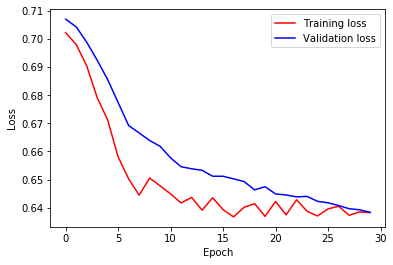

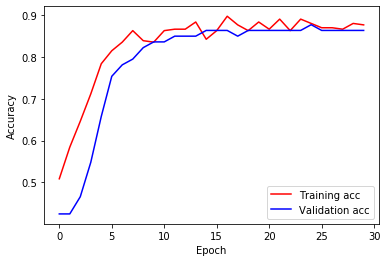

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the test images: 83 %
Training complete in 6m 49s


In [18]:
since = time.time()
myseed(seed=42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DATA
data, mapping = load_data(data_dir='/content/drive/My Drive/skin')
data_repited = pd.concat([data]*2, ignore_index=True)


unknown, _= load_data(data_dir='/content/drive/My Drive/dermatology')
train, val, test = data_split(data_repited)
data_transforms, df, image_datasets, dataloaders, dataset_sizes = get_loaders(size=100, batch_size=50,num_workers=4)

# MODEL
model = mymodel(unfreeze=True)
total_params, total_trainable_params = get_num_parameters(model) 
print(f'{total_params:,} total parameters.')
print(f'{total_trainable_params:,} training parameters.')

# PARAMS
import torch.optim as optim
from torch import nn
from torch.optim import lr_scheduler

weight = get_weight(train)
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# TRAIN
model, training_loss, validation_loss, training_acc, validation_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=30)
curve(training_loss, validation_loss, training_acc, validation_acc)

# Save the trained model
PATH = './model1.pth'
torch.save(model.state_dict(), PATH)
# Load our saved network
model.load_state_dict(torch.load(PATH))

#TEST
run_test()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Anja's model

4,722,018 total parameters.
4,722,018 training parameters.
Epoch 0/29
----------
train Loss: 0.6964 Acc: 0.5430
val Loss: 0.6906 Acc: 0.6301

Epoch 1/29
----------
train Loss: 0.6893 Acc: 0.7251
val Loss: 0.6842 Acc: 0.7397

Epoch 2/29
----------
train Loss: 0.6821 Acc: 0.7354
val Loss: 0.6774 Acc: 0.6849

Epoch 3/29
----------
train Loss: 0.6720 Acc: 0.6873
val Loss: 0.6715 Acc: 0.6575

Epoch 4/29
----------
train Loss: 0.6645 Acc: 0.7491
val Loss: 0.6653 Acc: 0.6575

Epoch 5/29
----------
train Loss: 0.6579 Acc: 0.7216
val Loss: 0.6609 Acc: 0.6712

Epoch 6/29
----------
train Loss: 0.6482 Acc: 0.7285
val Loss: 0.6549 Acc: 0.6164

Epoch 7/29
----------
train Loss: 0.6427 Acc: 0.7251
val Loss: 0.6540 Acc: 0.6164

Epoch 8/29
----------
train Loss: 0.6395 Acc: 0.7285
val Loss: 0.6549 Acc: 0.6164

Epoch 9/29
----------
train Loss: 0.6405 Acc: 0.6907
val Loss: 0.6530 Acc: 0.6164

Epoch 10/29
----------
train Loss: 0.6382 Acc: 0.7113
val Loss: 0.6514 Acc: 0.6164

Epoch 11/29
----------
trai

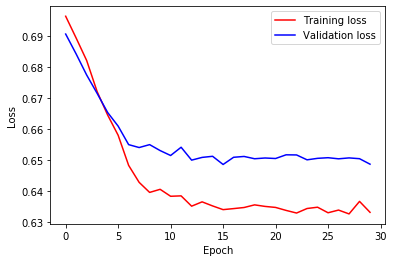

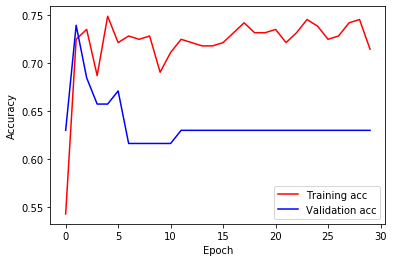

Accuracy of the network on the test images: 70 %
Training complete in 6m 17s


In [19]:
since = time.time()
myseed(seed=42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DATA
data, mapping = load_data(data_dir='/content/drive/My Drive/skin')
data_repited = pd.concat([data]*2, ignore_index=True)


unknown, _= load_data(data_dir='/content/drive/My Drive/dermatology')
train, val, test = data_split(data_repited)
data_transforms, df, image_datasets, dataloaders, dataset_sizes = get_loaders(size=100, batch_size=50,num_workers=4)

# MODEL
model = anjamodel(unfreeze=True)
total_params, total_trainable_params = get_num_parameters(model) 
print(f'{total_params:,} total parameters.')
print(f'{total_trainable_params:,} training parameters.')

# PARAMS
import torch.optim as optim
from torch import nn
from torch.optim import lr_scheduler

weight = get_weight(train)
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# TRAIN
model, training_loss, validation_loss, training_acc, validation_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=30)
curve(training_loss, validation_loss, training_acc, validation_acc)

# Save the trained model
PATH = './model2.pth'
torch.save(model.state_dict(), PATH)
# Load our saved network
model.load_state_dict(torch.load(PATH))

#TEST
run_test()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

### Predictions on unseen unlabeled data

Model1

In [20]:
last_df = make_predictions(mapping, df=unknown, phase='unknown', model=mymodel(unfreeze=True), PATH='./model1.pth')
last_df.head()

Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


,filenames,label,label_code,score,predictions,new_label
0,/content/drive/My Drive/dermatology/A46.9/pt4/...,NaN,-1,0.552539,0,not_skin
1,/content/drive/My Drive/dermatology/A46.9/pt4/...,NaN,-1,0.565363,1,skin
2,/content/drive/My Drive/dermatology/A46.9/pt3/...,NaN,-1,0.538239,1,skin
3,/content/drive/My Drive/dermatology/A46.9/pt3/...,NaN,-1,0.619638,1,skin
4,/content/drive/My Drive/dermatology/A46.9/pt3/...,NaN,-1,0.631963,1,skin


,new_label,predictions,score,image
0,not_skin,0,0.552539,
1,skin,1,0.565363,
2,skin,1,0.538239,
3,skin,1,0.619638,
4,skin,1,0.631963,
5,skin,1,0.655155,
6,skin,1,0.622846,
7,skin,1,0.573688,
8,not_skin,0,0.508618,
9,not_skin,0,0.567970,

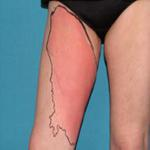
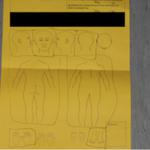
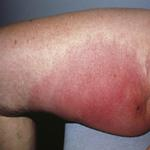
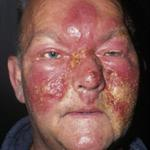
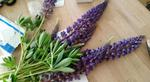
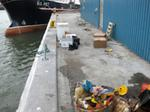
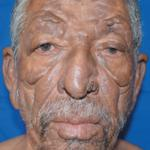
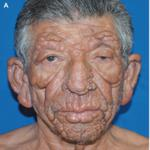
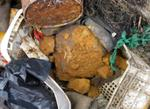
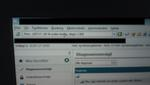
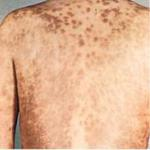

In [21]:
last_df['image'] = last_df.filenames.map(lambda f: get_thumbnail(f))
HTML(last_df[['new_label','predictions', 'score', 'image']].to_html(formatters={'image': image_formatter}, escape=False))

Anja's model

In [22]:
last_df = make_predictions(mapping, df=unknown, phase='unknown', model=anjamodel(unfreeze=True), PATH='./model2.pth')
last_df.head()

,filenames,label,label_code,score,predictions,new_label,image
0,/content/drive/My Drive/dermatology/A46.9/pt4/...,NaN,-1,0.483954,1,skin,<PIL.Image.Image image mode=RGB size=150x150 a...
1,/content/drive/My Drive/dermatology/A46.9/pt4/...,NaN,-1,0.528263,1,skin,<PIL.Image.Image image mode=RGB size=150x150 a...
2,/content/drive/My Drive/dermatology/A46.9/pt3/...,NaN,-1,0.562636,1,skin,<PIL.Image.Image image mode=RGB size=150x150 a...
3,/content/drive/My Drive/dermatology/A46.9/pt3/...,NaN,-1,0.597552,1,skin,<PIL.Image.Image image mode=RGB size=150x150 a...
4,/content/drive/My Drive/dermatology/A46.9/pt3/...,NaN,-1,0.577057,1,skin,<PIL.Image.Image image mode=RGB size=150x82 at...


,new_label,predictions,score,image
0,skin,1,0.483954,
1,skin,1,0.528263,
2,skin,1,0.562636,
3,skin,1,0.597552,
4,skin,1,0.577057,
5,skin,1,0.566032,
6,skin,1,0.552934,
7,skin,1,0.533676,
8,skin,1,0.559384,
9,skin,1,0.534010,

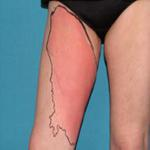
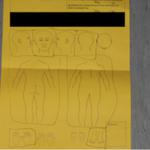
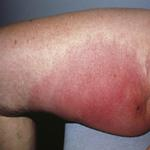
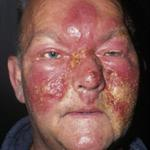
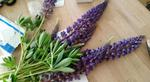
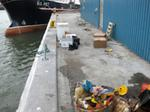
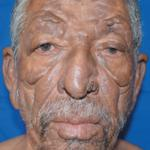
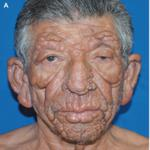
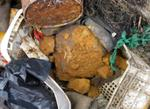
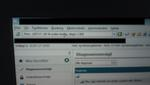
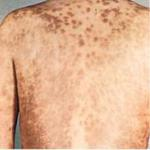

In [23]:
last_df['image'] = last_df.filenames.map(lambda f: get_thumbnail(f))
HTML(last_df[['new_label','predictions', 'score', 'image']].to_html(formatters={'image': image_formatter}, escape=False))